# Substance problem study

This notebook tries to answer the following:

1) Which age group shows the largest percentage of users with a possible substance problem? And which gender?

2) Which kind of professional is more prone to substance abuse?

3) Are users with kids or partners less likely to have a substance problem?

4) Do religious users are less likely to have a substance problem?

5) Do healthy choices (e.g. not smoking and plant-based diets) correlate negatively with substance abuse?

And last but not least, can we predict substance abuse with these variables?

Database: [OkCupid Profile Data](https://github.com/rudeboybert/JSE_OkCupid)

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [114]:
df = pd.read_csv("../data/profiles.csv")

## Selecting the useful variables

These are the variables that will help me address the questions posed in the intro:
- diet
- drinks
- drugs
- job
- offspring
- pets
- religion
- sex
- smokes
- status

Let's ditch all the rest:

- body_type
- education
- ethnicity
- height
- income
- last_online
- location
- orientation
- sign
- speaks
- essay from 0 to 9

In [115]:
df.drop(["body_type", "education", "ethnicity", "height", "income", "last_online", "location", "orientation",
        "sign", "speaks", "essay0", "essay1", "essay2", "essay3", "essay4", "essay5", "essay6",
        "essay7", "essay8", "essay9"], axis=1, inplace=True)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        59946 non-null  int64 
 1   diet       35551 non-null  object
 2   drinks     56961 non-null  object
 3   drugs      45866 non-null  object
 4   job        51748 non-null  object
 5   offspring  24385 non-null  object
 6   pets       40025 non-null  object
 7   religion   39720 non-null  object
 8   sex        59946 non-null  object
 9   smokes     54434 non-null  object
 10  status     59946 non-null  object
dtypes: int64(1), object(10)
memory usage: 5.0+ MB


The database has 60k rows, but there's a huge number of null values, especially in the `offspring` column. We'll have to deal with it.

In [117]:
df.dropna(axis=0, inplace=True)
df.shape

(8462, 11)

Dropping the NaNs leaves us with a ridiculousy smaller dataset, but still usable.

## Defining and creating the target variable

Firstly, we need to clearly define what substance abuse is. According to [Wikipedia](https://en.wikipedia.org/wiki/Substance_abuse):

> Substance abuse, also known as drug abuse, is use of a drug in amounts or by methods which are harmful to the individual or others. (...) Drugs most often associated with this term include: alcohol, amphetamines, barbiturates, benzodiazepines, cannabis, cocaine, hallucinogens, methaqualone, and opioids.

The OkCupid dataset isn't precise in terms of which drugs its users consume, but it gives us a few clues about quantity: 

- The `drinks` variable has 6 possible values: very often, often, socially, rarely, desperately, not at all
- The `drugs` variable has 3 possible values: never, sometimes, often

I'm going to assume that users who drink "very often", or use drugs "often" are likely candidates for the group of users with a substance problem. I dismissed "desperately" entries because this sounds more like an answer to signal you're cool.

I'm going to name it as `abuse`, and convert the possible values of `drinks` and `drugs` the variables `alcohol_problem`, `drugs_problem`, and `both_problems`, which will either be 0 or 1. 

In [118]:
# Not considering the "desperately" entries improved the model accuracy at the end of this notebook,
# which likely proves my point.
#df["alcohol_problem"] = df['drinks'].apply(lambda x: 1 if (x=="very often") or (x=="desperately") else 0)
df["alcohol_problem"] = df['drinks'].apply(lambda x: 1 if (x=="very often") else 0)
df.drop("drinks", axis=1, inplace=True)

df["drugs_problem"] = df['drugs'].apply(lambda x: 1 if (x=="often") else 0)
df.drop("drugs", axis=1, inplace=True)

df['both_problems'] = df["drugs_problem"] & df["alcohol_problem"]
df['alcohol_problem_only'] = df['alcohol_problem'] & ~df['drugs_problem']
df['drugs_problem_only'] = ~df['alcohol_problem'] & df['drugs_problem']

df['abuse'] = df['alcohol_problem'] | df['drugs_problem']

In [119]:
df["abuse"].value_counts()

0    8259
1     203
Name: abuse, dtype: int64

Less than 3% of the users in this dataset have a probable substance problem. This is a specially imbalanced dataset, so any attempts to predict an outcome will likely be impacted. Techniques to deal with it can be found at the end of the document.

## Answering the questions

### Question #1 - Which gender has the largest percentage of users with a possible substance problem? And which age?

In [120]:
df["age_group"] = pd.cut(df['age'], bins=[18,24,30,40,50,60,80])

In [121]:
df["female"] = df["sex"].replace({"m": 0, "f": 1})

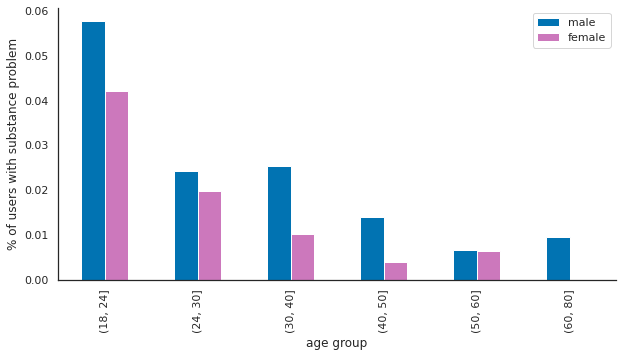

In [122]:
gender_colors = sns.color_palette("colorblind").as_hex()

male = df[df["female"] == 0].groupby("age_group")["abuse"].mean().to_frame()
female = df[df["female"] == 1].groupby("age_group")["abuse"].mean().to_frame()
sex = pd.concat([male, female], axis=1)
sex.columns = ["male", "female"]

sex.plot.bar(figsize=(10,5), color=[gender_colors[0], gender_colors[4]])
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

### Question #1 - Which kind of professional is more prone to substance abuse?

In [123]:
job_relative = df.groupby("job")['abuse'].mean().sort_values().to_frame()
job_relative*100

,abuse
job,
education / academia,0.571429
clerical / administrative,0.584795
banking / financial / real estate,0.911854
science / tech / engineering,1.224490
retired,1.234568
transportation,1.388889
law / legal services,1.435407
executive / management,1.682692
political / government,1.739130


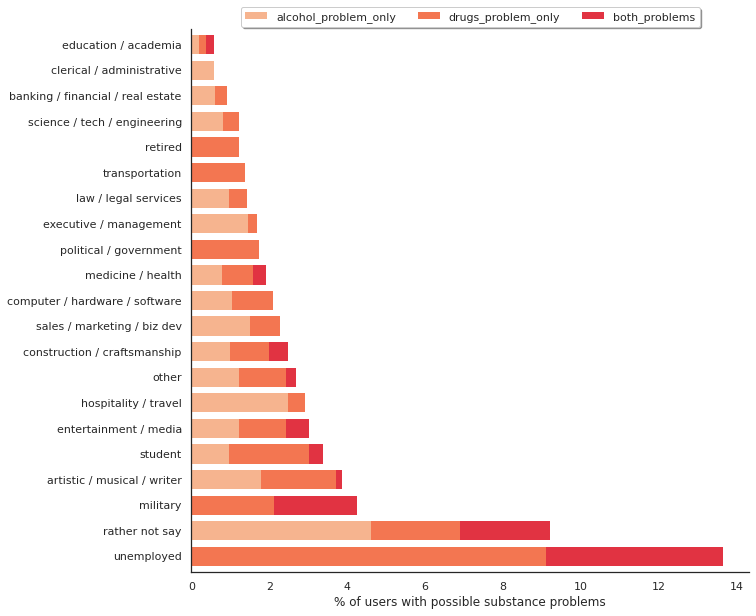

In [124]:
sns.set_palette("rocket_r")

jobs_stacked = df.groupby("job").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
jobs_stacked.drop('abuse', axis=1, inplace=True)
jobs_stacked.plot(kind='barh', stacked=True, figsize=(10,10), width=0.75, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

### Question 2) Does having kids decrease the likelihood of substance abuse?


According to the `okcupid_codebook.txt` file, the possible values of `status` are single, seeing someone, married, and in an open relationship. I'll replace the value "available" with the latter since it's more explainative.

In [125]:
df["status"] = df["status"].replace({"available": "in an open relationship"})

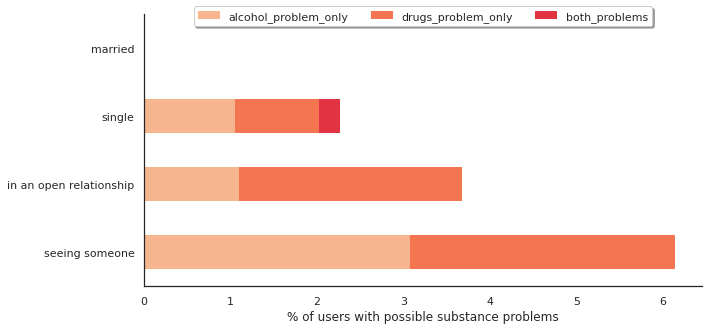

In [126]:
sns.set_palette("rocket_r")

status_stacked = df.groupby("status").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
status_stacked.drop('abuse', axis=1, inplace=True)
status_stacked.plot(kind='barh', stacked=True, figsize=(10,5), width=0.5, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

This variable is tricky. Almost 60% of the respondents chose not to say whether they had kids, so dropping the NaNs may greatly affect the outcomes.

Whoever said that "doesn't have kids" (and might or might not want them), or simply "wants kids" will have the offspring variable set to zero, while everything else will be replaced with ones.

In [127]:
df['offspring'].replace(['doesn&rsquo;t have kids',
                         'doesn&rsquo;t have kids, and doesn&rsquo;t want any',
                         'doesn&rsquo;t have kids, but might want them',
                         'doesn&rsquo;t have kids, but wants them',
                         'might want kids',
                         'doesn&rsquo;t want kids',
                         'wants kids'], 0, inplace=True)

df['offspring'].replace(['has a kid',
                         'has a kid, and might want more',
                         'has a kid, and wants more',
                         'has a kid, but doesn&rsquo;t want more',
                         'has kids',
                         'has kids, and might want more',
                         'has kids, and wants more',
                         'has kids, but doesn&rsquo;t want more',], 1, inplace=True)

There's also the problem of colinearity with age. Young adults are much less likely to have kids, and that will impact the outcome of the correlation study with substance abuse. It would be more reasonable to observe differences by age groups.

In [128]:
table_offspring = pd.concat([df["age_group"].value_counts(), (1-df.groupby("age_group")["offspring"].mean())*100], axis=1)
table_offspring.columns = ["no. of users", "percentage without kids"]
table_offspring.index.rename("age group", inplace=True)
table_offspring

,no. of users,percentage without kids
age group,,
"(18, 24]",1610,96.708075
"(24, 30]",2535,96.923077
"(30, 40]",2212,85.940325
"(40, 50]",1161,58.311800
"(50, 60]",616,33.441558
"(60, 80]",249,27.710843


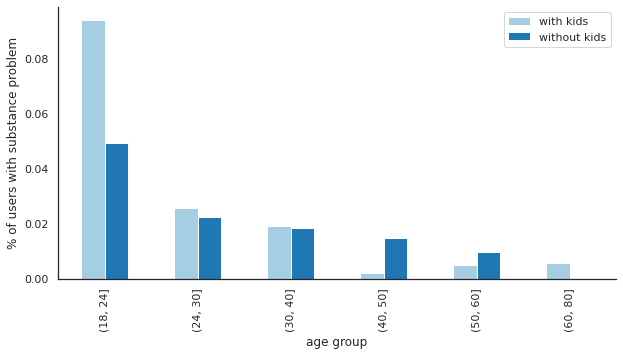

In [129]:
sns.set_palette("Paired")

has_kids_yes = df[df["offspring"] == True].groupby("age_group")["abuse"].mean().to_frame()
has_kids_no = df[df["offspring"] == False].groupby("age_group")["abuse"].mean().to_frame()
has_kids = pd.concat([has_kids_yes, has_kids_no], axis=1)
has_kids.columns = ["with kids", "without kids"]

has_kids.plot.bar(figsize=(10,5))
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

Now I'm curious. Kids may not help prevent substance abuse with age, but what about pets?

In [130]:
df['has_dogs'] = df['pets'].apply(lambda x: 1 if ("has dogs" in x) else 0)
df['has_cats'] = df['pets'].apply(lambda x: 1 if ("has cats" in x) else 0)
df['has_pets'] = df[['has_dogs', 'has_cats']].any(axis=1)

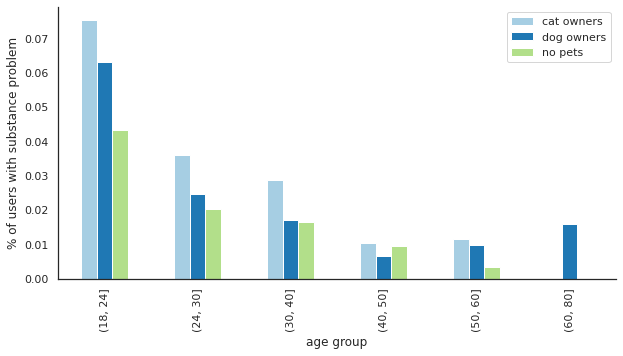

In [131]:
sns.set_palette("Paired")
has_cats = df[df["has_cats"] == True].groupby("age_group")["abuse"].mean().to_frame()
has_dogs = df[df["has_dogs"] == True].groupby("age_group")["abuse"].mean().to_frame()
has_none = df[df["has_pets"] == False].groupby("age_group")["abuse"].mean().to_frame()
has_pets = pd.concat([has_cats, has_dogs, has_none], axis=1)
has_pets.columns = ["cat owners", "dog owners", "no pets"]

has_pets.plot.bar(figsize=(10,5))
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

## 3) Does taking religion seriously help prevent substance abuse?

The `religion` variable has several possible values plus a few modifiers ("laughing about it, "somewhat serious about it", etc). I thought of creating a new variable out of these modifiers called `religious`, which is going to be 1 if `religion` is not atheism or agnosticism (for obvious reasons), and the `religion` modifier has the "very serious about it" modifier. 

In [132]:
df.dropna(axis=0, subset=["religion"], inplace=True)
df['religious'] = df['religion'].apply(lambda x: 1 if "very serious" in x else 0)
df['religious'] = ~df['religion'].isin(["agnosticism", "atheism"]) & df['religious'] == 1

df['religion'].replace([" and laughing about it",
                       " and somewhat serious about it",
                       " and very serious about it",
                       " but not too serious about it"], "", regex=True, inplace=True)

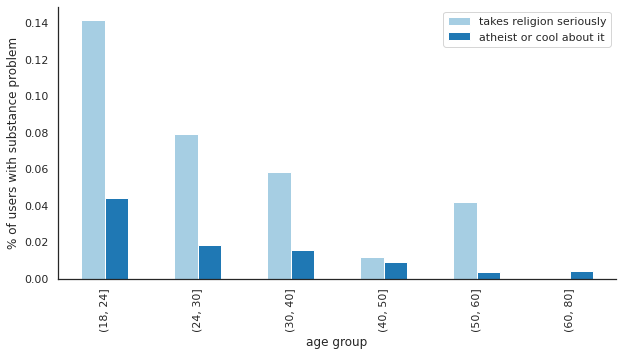

In [133]:
sns.set_palette("Paired")

religious_yes = df[df["religious"] == True].groupby("age_group")["abuse"].mean().to_frame()
religious_no = df[df["religious"] == False].groupby("age_group")["abuse"].mean().to_frame()
religious = pd.concat([religious_yes, religious_no], axis=1)
religious.columns = ["takes religion seriously", "atheist or cool about it"]

religious.plot.bar(figsize=(10,5))
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

### Question #5 - Do healthy choices like not smoking and vegetarian diets correlate negatively with substance abuse?

In [134]:
df["smokes"] = df["smokes"].replace({"yes": 1,
                                    "sometimes": 1,
                                    "when drinking": 1,
                                    "trying to quit": 1,
                                    "no": 0})

The "diet" variable has 6 possible values (anything, vegetarian, vegan, kosher, halal, and other) and 2 modifiers (mostly/strictly), which might create unnecessary dummy variables that won't add value to the model. So let's boil it down to diet type without the nuance.

In [135]:
df['vegetarian'] = df['diet'].apply(lambda x: 1 if ("vegetarian" in x) or ("vegan" in x) else 0)

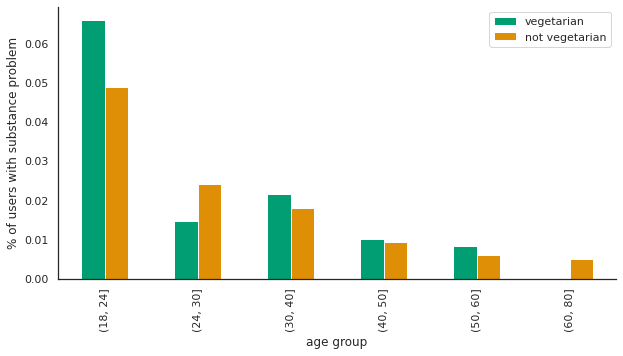

In [136]:
colors = sns.color_palette("colorblind").as_hex()

vegetarian_yes = df[df["vegetarian"] == True].groupby("age_group")["abuse"].mean().to_frame()
vegetarian_no = df[df["vegetarian"] == False].groupby("age_group")["abuse"].mean().to_frame()
vegetarian = pd.concat([vegetarian_yes, vegetarian_no], axis=1)
vegetarian.columns = ["vegetarian", "not vegetarian"]

vegetarian.plot.bar(figsize=(10,5), color=[colors[2], colors[1]])
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

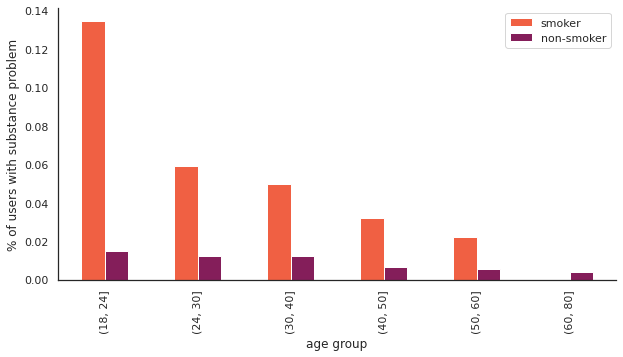

In [26]:
sns.set_palette("rocket_r", n_colors=2)

df.dropna(axis=0, subset=["smokes"], inplace=True)

smokes_yes = df[df["smokes"] == True].groupby("age_group")["abuse"].mean().to_frame()
smokes_no = df[df["smokes"] == False].groupby("age_group")["abuse"].mean().to_frame()
smokes = pd.concat([smokes_yes, smokes_no], axis=1)
smokes.columns = ["smoker", "non-smoker"]

smokes.plot.bar(figsize=(10,5))
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

## Prediction

Let's clear up all unused columns.

In [56]:
df["unemployed"] = (df["job"] == "unemployed") | (df["job"] == "rather not say")
df["married"] = df["status"] == "married"

In [57]:
df_useful = df.drop(["diet","pets","religion","age_group", "alcohol_problem",
                    "alcohol_problem_only", "drugs_problem", "drugs_problem_only",
                    "both_problems", "has_pets", "job", "status", "sex"], axis=1)

There are a few categorical variables remaining. Let's transform them into dummy variables.

In [58]:
df_useful.dtypes

age           int64
offspring     int64
smokes        int64
abuse         int64
female        int64
has_dogs      int64
has_cats      int64
religious      bool
vegetarian    int64
unemployed     bool
married        bool
dtype: object

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score, plot_roc_curve
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline

In [60]:
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))

y = df_useful["abuse"]
X = df_useful.drop(["abuse"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# concatenate our training data back together
df_train = pd.concat([X_train, y_train], axis=1)

In [61]:
# separate minority and majority classes
not_abuse = df_train[df_train["abuse"] == 0]
abuse =  df_train[df_train["abuse"] == 1]

# upsample minority
abuse_upsampled = resample(abuse,
                          replace=True, # sample with replacement
                          n_samples=len(not_abuse), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_abuse, abuse_upsampled])

y_train = upsampled.abuse
X_train = upsampled.drop('abuse', axis=1)

In [62]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=200))])

In [137]:
coef_table = pd.DataFrame(model.named_steps["logisticregression"].coef_[0], index=X_train.columns, columns=["coef"])
coef_table

,coef
age,-0.515595
offspring,0.047919
smokes,0.794454
female,-0.247888
has_dogs,-0.045085
has_cats,0.325116
religious,0.390841
vegetarian,0.018743
unemployed,0.333458
married,-0.419006


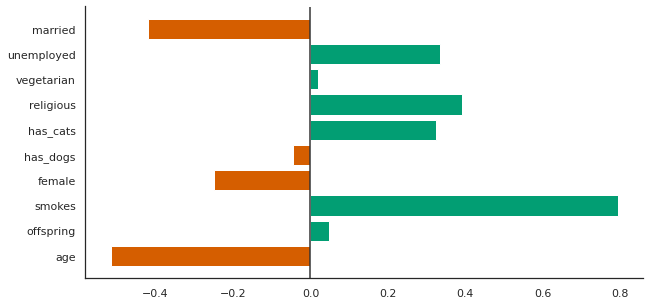

In [138]:
palette = sns.color_palette("colorblind").as_hex()
colors = [palette[3] if x < 0 else palette[2] for x in coef_table.values]
pos = np.arange(len(coef_table))
plt.figure(figsize=(10,5))
plt.barh(pos, coef_table["coef"], color=colors)
plt.yticks(pos, coef_table.index)
plt.axvline(x=0, color='.2')
sns.despine()

In [67]:
print("Accuracy:",model.score(X_test, y_test))
print("Recall:",recall_score(y_test, model.predict(X_test)))
print("F1 Score:",f1_score(y_test, model.predict(X_test)))
print("ROC AUC:",roc_auc_score(y_test, model.predict(X_test)))

Accuracy: 0.7784997046662729
Recall: 0.825
F1 Score: 0.14965986394557823
ROC AUC: 0.8011872353297035


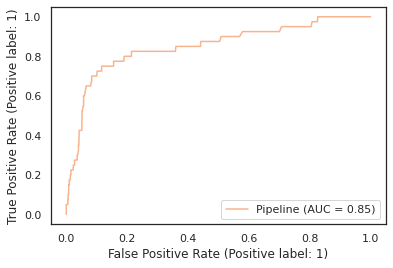

In [68]:
plot_roc_curve(model, X_test, y_test)

In [69]:
print("Recall: {:.2f}".format(recall_score(y_test, model.predict(X_test))))

Recall: 0.82


In [70]:
(y_test == model.predict(X_test))[y_test == 0].mean()

0.7773744706594071